# IndShockConsumerType_extend-Example

By William Du

The following material assumes the reader is familiar with the IndShockConsumerType documentation. See [here](https://github.com/econ-ark/HARK/blob/master/examples/ConsIndShockModel/IndShockConsumerType.ipynb) for details.

In [1]:
from __future__ import print_function
import sys 
import os
from copy import copy, deepcopy
import numpy as np
import scipy as sc
from scipy import sparse as sp
from HARK.ConsumptionSaving.ConsIndShockModel3 import IndShockConsumerType
import matplotlib.pyplot as plt


This notebook provides two examples on how to implement the following three functions:

#####  Define_Distribution_Grid 
- computes the grid of normalized market resources and the grid permanent income storing each as attributes.

##### Calc_Transition_Matrix 
- computes the transition matrix, consumption policy grid, and an asset policy grid all stored as attributes. If the problem is finite horizon, this function stores lists of transition matrices, consumption policies and asset policies grid for each period of the problem.

##### Calc_Ergodic_Dist 
- computes the ergodic distribution stored as attributes. The distribution is stored as a vector (self.VecErgDstn) and as an array with row dimension equal to the length of the grid over market resources and column dimension equal to the length of the grid over permanent income  (self.ErgDstn)


# Example 1: 
# Computing Aggregate Consumption: Transition Matrix vs Simulation

This section details how to compute aggregate consumption and aggregate assets using transition matrices and compares the results against aggregate values produced by Monte Carlo Simulate methods.

### Create and solve an Instance of IndShockConsumerType_extend 

We begin by creating an instance of the IndShockConsumerType_extend and solving his problem.

### Specify Parameters

In [2]:

Dict={
    # Parameters shared with the perfect foresight model
    "CRRA":2,                             # Coefficient of relative risk aversion
    "Rfree": 1.05**.25,                   # Interest factor on assets
    "DiscFac": 0.97,                      # Intertemporal discount factor
    "LivPrb" : [.99375],                  # Survival probability
    "PermGroFac" :[1.00],                 # Permanent income growth factor

    # Parameters that specify the income distribution over the lifecycle
   
    "PermShkStd" :  [.05],                 # Standard deviation of log permanent shocks to income
    "PermShkCount" : 5,                    # Number of points in discrete approximation to permanent income shocks
    "TranShkStd" : [.3],                   # Standard deviation of log transitory shocks to income
    "TranShkCount" : 5,                    # Number of points in discrete approximation to transitory income shocks
    "UnempPrb" : 0.05,                     # Probability of unemployment while working
    "IncUnemp" :  .2,                      # Unemployment benefits replacement rate
    "UnempPrbRet" : 0.0005,                # Probability of "unemployment" while retired
    "IncUnempRet" : 0.0,                   # "Unemployment" benefits when retired
    "T_retire" : 0,                        # Period of retirement (0 --> no retirement)
    "tax_rate" : .3,                       # Flat income tax rate (legacy parameter, will be removed in future)

    # Parameters for constructing the "assets above minimum" grid
    "aXtraMin" : 0.001,                    # Minimum end-of-period "assets above minimum" value
    "aXtraMax" : 20,                       # Maximum end-of-period "assets above minimum" value
    "aXtraCount" : 48,                     # Number of points in the base grid of "assets above minimum"
    "aXtraNestFac" : 3,                    # Exponential nesting factor when constructing "assets above minimum" grid
    "aXtraExtra" : [None],                 # Additional values to add to aXtraGrid

    # A few other parameters
    "BoroCnstArt" : 0.0,                   # Artificial borrowing constraint; imposed minimum level of end-of period assets
    "vFuncBool" : False,                   # Whether to calculate the value function during solution
    "CubicBool" : False,                   # Preference shocks currently only compatible with linear cFunc
    "T_cycle" : 1,                         # Number of periods in the cycle for this agent type

    # Parameters only used in simulation
    "AgentCount" : 10000,                  # Number of agents of this type
    "T_sim" : 2000,                        # Number of periods to simulate
    "aNrmInitMean" : np.log(1.6)-(.5**2)/2,# Mean of log initial assets
    "aNrmInitStd"  : .5,                   # Standard deviation of log initial assets
    "pLvlInitMean" : 0.0,                  # Mean of log initial permanent income
    "pLvlInitStd"  : 0.0,                  # Standard deviation of log initial permanent income
    "PermGroFacAgg" : 1.0,                 # Aggregate permanent income growth factor
    "T_age" : None,                        # Age after which simulated agents are automatically killed
    
     }



In [3]:
example1 = IndShockConsumerType(**Dict, verbose = 0)
example1.cycles = 0
example1.solve()


## Method 1: Simulate 

Below we use Monte Carlo Simulation methods to compute the level of aggregate consumption and aggregate assets.

In [4]:
example1.initialize_sim()
example1.simulate() #simulate

Simulated_Consumption = np.mean((example1.state_now['mNrm'] - example1.state_now['aNrm'])*example1.state_now['pLvl']) #Compute aggregate consumption
Simulated_Assets = np.mean(example1.state_now['aNrm']*example1.state_now['pLvl']) #Compute Aggregate assets

## Method 2: Applying Transition Matrices

To compute the level of aggregate consumption using the transition matrix, we begin by defining the grid over the distribution of market resources and permanent income and store the distribution of permanent income as p . 

In [5]:
example1.define_distribution_grid()
p = example1.dist_pGrid # Grid of permanent income levels

We then calculate the transition matrix and store the consumption and asset policy grid as c and asset. The transition matrix is stored as the attribute example1.TranMatrix to be used by the Calc_ergodic_Dist function.

In [6]:
example1.calc_transition_matrix()
c = example1.cPolGrid #Consumption Policy Grid
asset = example1.aPolGrid # Asset Policy Grid

Finally we compute the ergodic distribution and store the distribution as a vector. Under the hood of this function, it takes in the transition matrix calculated in the previous function (example1.TranMatrix) and computes the ergodic distribution.

In [7]:
example1.calc_ergodic_dist()
vecDstn = example1.vec_erg_dstn # Distribution of market resources as a vector 

With the transition matrix, consumption and asset policy grid, and the distribution vector, we can now compute aggregate consumption.

In [8]:

gridc = np.zeros((len(c),len(p))) 
grida = np.zeros((len(asset),len(p)))

#Transform normalized grid of consumption and asset policy into levels
for j in range(len(p)):
    gridc[:,j] = p[j]*c # Array of all possible combinations of consumption and permanent income.
    grida[:,j] = p[j]*asset # Array of all possible combinations of assets and permanent income.
    
AggC = np.dot(gridc.flatten(),vecDstn) # Compute aggregate consumption by multiplying consumption policy grid by distribution
AggA = np.dot(grida.flatten() ,vecDstn)# Compute aggregate assets by multiplying asset policy grid by distribution

We being by defining the grid over the distribution of market resources and permanent income.

##  Comparing Outputs of Both Methods

In [9]:
print('TranMatrix Assets =' + str(AggA[0]))
print('Simulated Assets = ' +str(Simulated_Assets))

print('TranMatrix Consumption =' + str(AggC[0]))
print('Simulated Consumption = ' +str(Simulated_Consumption))

TranMatrix Assets =1.1493665253316738
Simulated Assets = 1.1878906213808793
TranMatrix Consumption =1.0067640869283523
Simulated Consumption = 1.0076918586002666


## A Different Calibration

As a robustness check, the same exercise is implemented with a different set of parameters to see whether simulated aggregates match the aggregates produced with transition matrices. 

In [10]:
example2 = IndShockConsumerType(**Dict, verbose = 0)
example2.cycles = 0

#New Parameters
example2.IncUnemp = .5
example2.UnempPrb = .1
example2.PermShkStd = [.03]
example2.TranShkStd = [.1]
example2.tax_rate = .1
example2.Rfree = 1.02**.25
example2.DiscFac = .99

In [11]:
example2.solve()
example2.initialize_sim()
example2.simulate()


Simulated_Consumption = np.mean((example2.state_now['mNrm'] - example2.state_now['aNrm'])*example2.state_now['pLvl'])
Simulated_Assets = np.mean(example2.state_now['aNrm']*example2.state_now['pLvl'])

In [12]:
example2.define_distribution_grid()
p = example2.dist_pGrid # Grid of permanent income levels

example2.calc_transition_matrix()
c = example2.cPolGrid #Consumption Policy Grid
asset = example2.aPolGrid # Asset Policy Grid

example2.calc_ergodic_dist()
vecDstn = example2.vec_erg_dstn # Distribution as a vector

gridc = np.zeros((len(c),len(p)))
grida = np.zeros((len(asset),len(p)))

#Transform normalized grid of consumption and asset policy into levels
for j in range(len(p)):
    gridc[:,j] = p[j]*c
    grida[:,j] = p[j]*asset
    
AggC = np.dot(gridc.flatten(),vecDstn)
AggA = np.dot(grida.flatten() ,vecDstn)   

In [13]:
print('TranMatrix Assets =' + str(AggA[0]))
print('Simulated Assets = ' +str(Simulated_Assets))

print('TranMatrix Consumption =' + str(AggC[0]))
print('Simulated Consumption = ' +str(Simulated_Consumption))

TranMatrix Assets =1.865483816969303
Simulated Assets = 1.907460492421025
TranMatrix Consumption =0.9973327527616564
Simulated Consumption = 0.9974730909870996


Note* Accuracy decreases as standard deviation of permanent shocks increases.

# Example 2: 
# Computing the Path of Aggregate Consumption given a Pertubation in the Interest Rate

This section details an experiment where agents anticipates a change in the interest rate at period $t = 10$ and plots the paths of aggregate consumption and aggregate assets.

## Compute Steady State Aggregate Consumption

We begin by computing the steady state level of aggregate consumption. This is necesary to obtain the steady state consumption function to be inputed as the terminal solution for the next agent (see below). 

In [14]:
ss = IndShockConsumerType(**Dict, verbose = 0) #
ss.cycles = 0
ss.solve()

ss.define_distribution_grid()
p = ss.dist_pGrid # Grid of permanent income 

ss.calc_transition_matrix()
c = ss.cPolGrid # Normalized Consumption Policy grid
a = ss.aPolGrid #Normalized Asset Policy grid

ss.calc_ergodic_dist()
vecDstn = ss.vec_erg_dstn # Distribution over market resources as a vector

gridc = np.dot( c.reshape( len(c), 1 ) , p.reshape( 1 , len(p) ) ) #Transform grid from normalized consumption to level of consumption
grida = np.dot( a.reshape( len(a), 1 ) , p.reshape( 1 , len(p) ) ) #Transform grid from normalized assets to level of assets

C_ss = np.dot(gridc.flatten(),vecDstn) # Compute steady state aggregate consumption
A_ss = np.dot(grida.flatten() ,vecDstn)# Compute steady state aggregate assets     



In [15]:
print('steady state Consumption: ' + str(C_ss[0]))
print('steady state Assets: ' + str(A_ss[0]))

steady state Consumption: 1.0067640866750511
steady state Assets: 1.1493665250639191


## Solving an Agent who Anticipates a Change in the Interest Rate

We need to specify an agent who faces a finite horizon problem. The agent now takes in lists of parameters. Each list is the length of the horizon ($T=30$) in the model. Elements of each list indicate the value of the parameter faced in the respective period.

In [16]:
params = deepcopy(Dict)
params['T_cycle']= 30 # Set Horizon Length T = 30
params['LivPrb']= params['T_cycle']*[ss.LivPrb[0]] # list of living probabilities
params['PermGroFac']= params['T_cycle']*[1] # list of permanent growth factor
params['PermShkStd'] = params['T_cycle']*[ss.PermShkStd[0]] # list of permanent shock standard deviations
params['TranShkStd']= params['T_cycle']*[ss.TranShkStd[0]] # list of transitory shock standard deviations

FinHorizonAgent = IndShockConsumerType(**params, verbose = 0) # input these parameters into the agent.
FinHorizonAgent.cycles = 1
FinHorizonAgent.del_from_time_inv('Rfree') #delete Rfree from time invariant list since it varies overtime
FinHorizonAgent.add_to_time_vary('Rfree')

#Below is crucial!!
FinHorizonAgent.cFunc_terminal_ = deepcopy(ss.solution[0].cFunc) # Set Terminal Solution as Steady State Consumption Function.
                                                                 # This is to ensure after the shock the economy returns to its original steady state.



### Implement perturbation in interest rate

We specify the list of interest rates the agent faces by FinHorizonAgent.Rfree.
Note the 10th element of the list FinHorizonAgent.Rfree has an interest rate that is $.01$ greater than the steady state level.

In [17]:
dx=.01 # Change in the Interest Rate
i = 10 # Period in which the change in the interest rate occurs
FinHorizonAgent.Rfree = (i)*[ss.Rfree] + [ss.Rfree + dx] + (params['T_cycle'] - i -1 )*[ss.Rfree] # Sequence of interest rates the agent faces


### Solve Agent and Calculate Transition Matrices

In [18]:
FinHorizonAgent.solve() #Solve the Agent's problem
FinHorizonAgent.define_distribution_grid() 
FinHorizonAgent.calc_transition_matrix()


Since this is a finite horizon problem now, FinHorizonAgent.Calc_Transition_Matrix() now generates:
- a list of transition matrices for each period (FinHorizonAgent.TranMatrix)
- a list of consumption policies for each period (FinHorizonAgent.cPolGrid)
- a list of asset policies for each period (FinHorizonAgent.aPolGrid)





### Calculate Paths of Aggregate Consumption and Aggregate Assets

In [19]:
FinHorizonAgent.calc_agg_path(vecDstn)

FinHorizonAgent.calc_agg_path(vecDstn) calculates the time series of aggregate consumption and aggregate assets. The function requires the initial distribution as an argument which in this case is the steady state distribution "vecDstn".

### Path of Aggregate Consumption given an anticipated interest rate shock at $t=10$

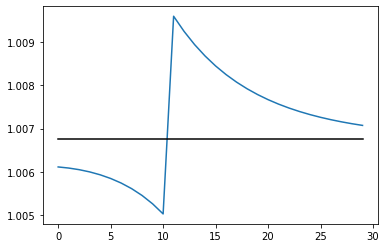

In [20]:
plt.plot(FinHorizonAgent.AggC)
plt.plot(np.ones( len(FinHorizonAgent.AggA) )* 1.00676409, 'k')
#plt.ylim([1.004,1.01])
plt.show()


### Path of Aggregate Assets given an anticipated interest rate shock at $t=10$

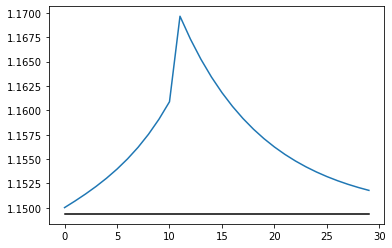

In [21]:
plt.plot(FinHorizonAgent.AggA)
plt.plot(np.ones( len(FinHorizonAgent.AggA) )* A_ss, 'k')
#plt.ylim([1.004,1.01])
plt.show()